In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
import matplotlib.pyplot as plt

In [3]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split('_')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [4]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'cooling_flag_1', 'cooling_flag_2', 'time_index', 'condition'],
      dtype='object')

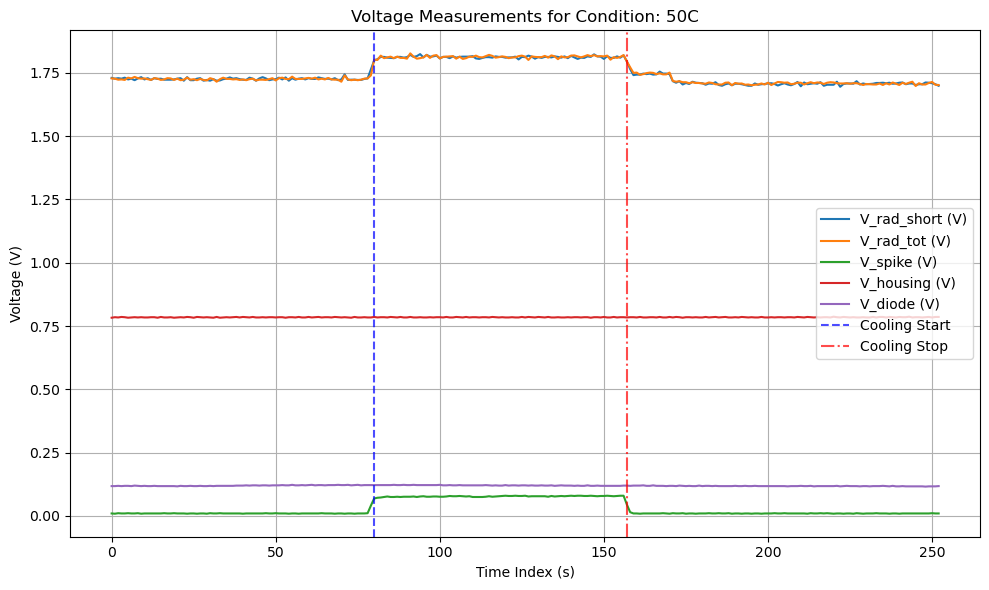

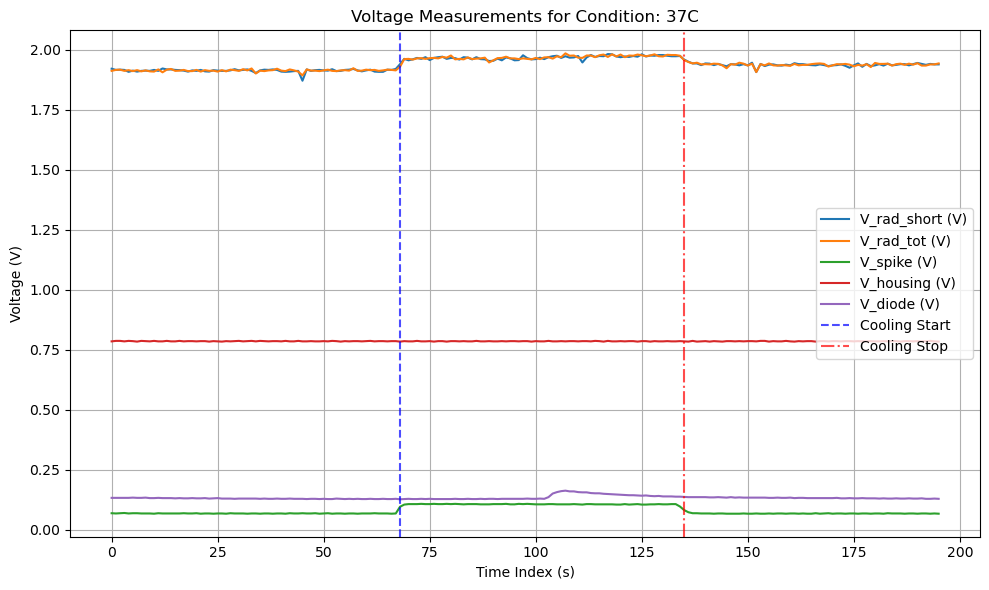

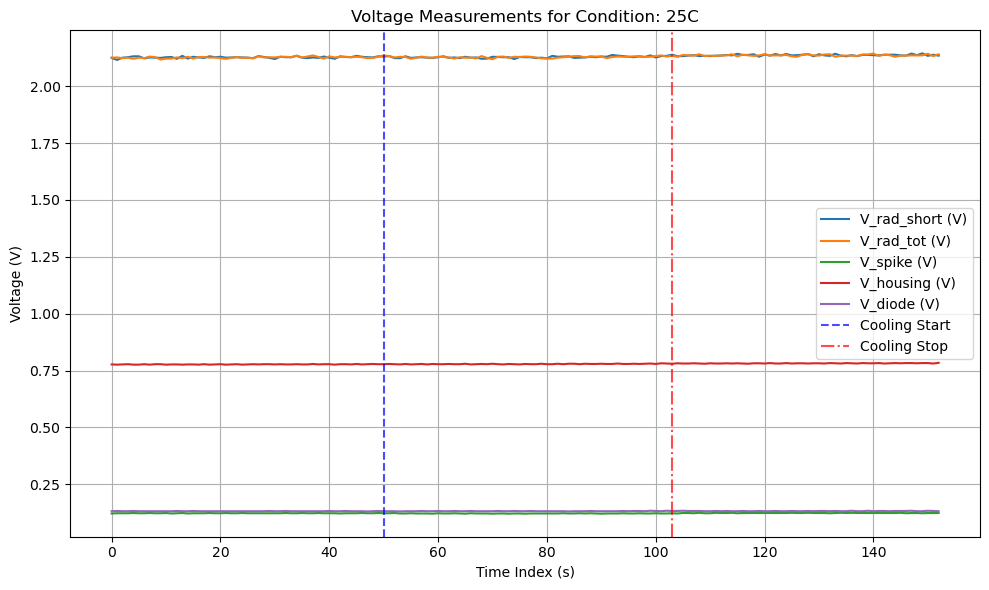

In [5]:
# Plot V_rad_short, V_rad_tot, V_spike, V_housing, V_diode vs sample index for each condition
# Add vertical lines for cooling start (cooling_flag_1: 0->1) and stop (1->0)

variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    # Find cooling start (0->1) and stop (1->0) indices
    flag = subset['cooling_flag_1'].values
    time_idx = subset['time_index'].values[:-1]
    starts = time_idx[(flag[:-1] == 0) & (flag[1:] == 1)]+1
    stops = time_idx[(flag[:-1] == 1) & (flag[1:] == 0)]+1
    for s in starts:
        plt.axvline(s, color='blue', linestyle='--', alpha=0.7, label='Cooling Start')
    for s in stops:
        plt.axvline(s, color='red', linestyle='-.', alpha=0.7, label='Cooling Stop')
    # Avoid duplicate legend entries
    handles, plot_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(plot_labels, handles))
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
# Create a new column 'condition_cooling' based on 'condition' and 'cooling_flag_1'
def label_cooling(row):
    if row['cooling_flag_1'] == 1:
        return f"{row['condition']}_with_cooling"
    else:
        return f"{row['condition']}_no_cooling"

all_X['condition_cooling'] = all_X.apply(label_cooling, axis=1)

In [7]:
all_X.condition_cooling.unique()

array(['50C_no_cooling', '50C_with_cooling', '37C_no_cooling',
       '37C_with_cooling', '25C_no_cooling', '25C_with_cooling'],
      dtype=object)

In [24]:
summary = all_X.groupby(['condition', 'condition_cooling'])['V_rad_tot'].mean().reset_index()
summary


,condition,condition_cooling,V_rad_tot
0,25C,25C_no_cooling,2130.600000
1,25C,25C_with_cooling,2127.509434
2,37C,37C_no_cooling,1924.224806
3,37C,37C_with_cooling,1967.298507
4,50C,50C_no_cooling,1719.630682
5,50C,50C_with_cooling,1812.883117


In [25]:
all_X['V_housing'].mean()

np.float64(783.2674418604652)

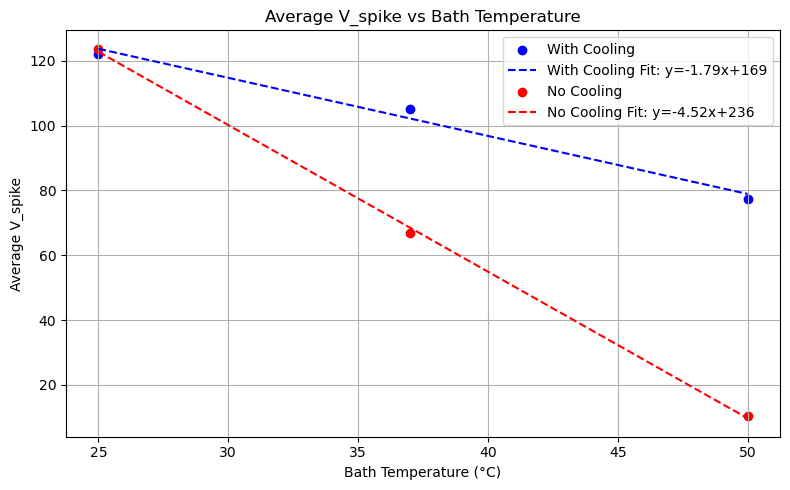

In [8]:
from scipy.stats import linregress

# Prepare data: group by 'condition' and 'condition_cooling', compute mean V_spike
summary = all_X.groupby(['condition', 'condition_cooling'])['V_spike'].mean().reset_index()

# Map temperature to numeric for regression
summary['temp_C'] = summary['condition'].str.replace('C', '').astype(float)

# Separate with and without cooling
with_cooling = summary[summary['condition_cooling'].str.contains('with_cooling')]
no_cooling = summary[summary['condition_cooling'].str.contains('no_cooling')]

plt.figure(figsize=(8, 5))

# Plot and fit for 'with cooling'
if not with_cooling.empty:
    x1 = with_cooling['temp_C']
    y1 = with_cooling['V_spike']
    plt.scatter(x1, y1, color='blue', label='With Cooling')
    slope1, intercept1, _, _, _ = linregress(x1, y1)
    plt.plot(x1, slope1 * x1 + intercept1, color='blue', linestyle='--',
             label=f'With Cooling Fit: y={slope1:.3g}x+{intercept1:.3g}')

# Plot and fit for 'no cooling'
if not no_cooling.empty:
    x2 = no_cooling['temp_C']
    y2 = no_cooling['V_spike']
    plt.scatter(x2, y2, color='red', label='No Cooling')
    slope2, intercept2, _, _, _ = linregress(x2, y2)
    plt.plot(x2, slope2 * x2 + intercept2, color='red', linestyle='--',
             label=f'No Cooling Fit: y={slope2:.3g}x+{intercept2:.3g}')

plt.xlabel('Bath Temperature (°C)')
plt.ylabel('Average V_spike')
plt.title('Average V_spike vs Bath Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

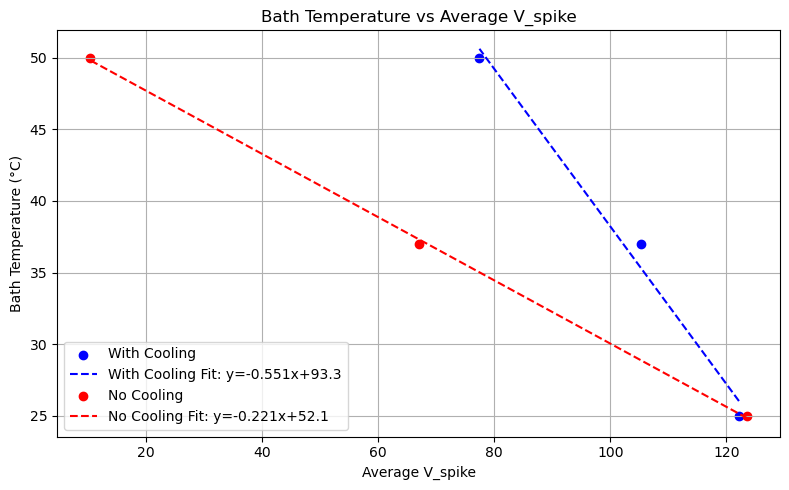

In [9]:
plt.figure(figsize=(8, 5))

# Plot and fit for 'with cooling'
if not with_cooling.empty:
    x1 = with_cooling['V_spike']
    y1 = with_cooling['temp_C']
    plt.scatter(x1, y1, color='blue', label='With Cooling')
    # Fit: temp_C = a * V_spike + b
    slope1, intercept1, _, _, _ = linregress(x1, y1)
    plt.plot(x1, slope1 * x1 + intercept1, color='blue', linestyle='--',
             label=f'With Cooling Fit: y={slope1:.3g}x+{intercept1:.3g}')

# Plot and fit for 'no cooling'
if not no_cooling.empty:
    x2 = no_cooling['V_spike']
    y2 = no_cooling['temp_C']
    plt.scatter(x2, y2, color='red', label='No Cooling')
    slope2, intercept2, _, _, _ = linregress(x2, y2)
    plt.plot(x2, slope2 * x2 + intercept2, color='red', linestyle='--',
             label=f'No Cooling Fit: y={slope2:.3g}x+{intercept2:.3g}')

plt.xlabel('Average V_spike')
plt.ylabel('Bath Temperature (°C)')
plt.title('Bath Temperature vs Average V_spike')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
all_X.describe()

,V_rad_short,V_rad_tot,V_housing,V_diode,V_spike,cooling_flag_1,cooling_flag_2,time_index
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.0,602.000000
mean,1906.807309,1907.141196,783.267442,127.039867,70.299003,0.327243,0.0,104.013289
std,157.184227,156.867224,2.663596,7.706022,43.703284,0.469597,0.0,64.831586
min,1695.000000,1698.000000,776.000000,116.000000,9.000000,0.000000,0.0,0.000000
25%,1730.250000,1729.250000,783.000000,120.000000,11.000000,0.000000,0.0,50.000000
50%,1915.000000,1914.000000,784.000000,128.000000,68.000000,0.000000,0.0,100.000000
75%,2119.000000,2119.500000,785.000000,132.000000,121.000000,1.000000,0.0,150.000000
max,2144.000000,2143.000000,787.000000,162.000000,125.000000,1.000000,0.0,252.000000


In [11]:
# Save the slope and intercept for no cooling
no_cooling_slope = slope2
no_cooling_intercept = intercept2

def temp_from_vspike_no_cooling(v_spike):
    """
    Estimate bath temperature from V_spike for no cooling condition.
    """
    return no_cooling_slope * v_spike + no_cooling_intercept

# Math Derivation of T tissue

$$ T_{rad-tot} = (1- AL) \cdot T_{tissue}+ AL \cdot T_{antenna} $$  

$$ T_{tissue} = \frac{T_{rad-tot}}{1- AL} - \frac{AL \cdot T_{antenna}}{1- AL} $$  

My calculated AL with the VNA = 0.37

$$
T_{antenna} = \ V_{spike} \cdot AntennaSlope + AntennaOffset 
$$

$$
T_{housing} = \ V_{housing} \cdot HousingSlope + HousingOffset 
$$

$$
T_{rad-tot} = \left( \frac{2 \cdot V_{rad-tot}-4 - RadOffset0 - RadOffsetchange \cdot T_{housing}}{Radslope0 + RadSlopeChange \cdot T_{housing}} \right) + T_{housing}
$$

With my calibrated parameters: 
- RadSlopeChange = 0.000563 V/ºC^2
- RadSlope0 = -0.057 V/ºC
- RadOffsetChange = 0.000497 V/ºC
- RadOffset0 = 0.180 V
- HousingSlope = 0.0983 (ºC / mV)
- HousingOffset = -50.29 (ºC)

In [18]:
# Define parameter values (units: V and °C)
AL = 0.37  # unitless

AntennaSlope = slope2*1e3  # °C/V
AntennaOffset = intercept2 # °C

# HousingSlope = 0.0983*1e3  # °C/V
# HousingOffset = -50.29  # °C

# RadSlopeChange = 0.000563  # V/°C²
# RadSlope0 = -0.057           # V/°C
# RadOffsetChange = 0.000497 # V/°C
# RadOffset0 = 0.180          # V

HousingSlope = 0.098*1e3  # °C/V
HousingOffset = -49.2  # °C

RadSlopeChange = 0.00054  # V/°C²
RadSlope0 = -0.056           # V/°C
RadOffsetChange = 9.5e-5 # V/°C
RadOffset0 = 0.191          # V


In [19]:
# Convert voltages from mV to V
all_X['V_rad_tot_V'] = all_X['V_rad_tot'] / 1000
all_X['V_housing_V'] = all_X['V_housing'] / 1000
all_X['V_spike_V'] = all_X['V_spike'] / 1000

# Calculate T_antenna
all_X['T_antenna'] = all_X['V_spike_V'] * AntennaSlope + AntennaOffset

# Calculate housing term for T_rad-tot
housing_temp = all_X['V_housing_V'] * HousingSlope + HousingOffset
all_X['T_housing'] = housing_temp

# Calculate numerator and denominator for T_rad-tot
numerator = (
    2 * all_X['V_rad_tot_V']
    - 4
    - RadOffset0
    - RadOffsetChange * housing_temp
)
denominator = (
    RadSlope0
    + RadSlopeChange * housing_temp
)

all_X['T_rad-tot'] = numerator / denominator + housing_temp

# Calculate T_tissue
all_X['T_tissue'] = (
    all_X['T_rad-tot'] / (1 - AL)
    - (AL * all_X['T_antenna']) / (1 - AL)
)

In [20]:
all_X.describe()

,V_rad_short,V_rad_tot,V_housing,V_diode,V_spike,cooling_flag_1,cooling_flag_2,time_index,V_rad_tot_V,V_housing_V,V_spike_V,T_antenna,T_housing,T_rad-tot,T_tissue
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.0,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,1906.807309,1907.141196,783.267442,127.039867,70.299003,0.327243,0.0,104.013289,1.907141,0.783267,0.070299,36.602534,27.560209,36.805097,36.924062
std,157.184227,156.867224,2.663596,7.706022,43.703284,0.469597,0.0,64.831586,0.156867,0.002664,0.043703,9.655085,0.261032,7.835077,7.417859
min,1695.000000,1698.000000,776.000000,116.000000,9.000000,0.000000,0.0,0.000000,1.698000,0.776000,0.009000,24.517795,26.848000,25.192597,25.337475
25%,1730.250000,1729.250000,783.000000,120.000000,11.000000,0.000000,0.0,50.000000,1.729250,0.783000,0.011000,25.401490,27.534000,26.031142,26.689759
50%,1915.000000,1914.000000,784.000000,128.000000,68.000000,0.000000,0.0,100.000000,1.914000,0.784000,0.068000,37.110438,27.632000,36.587417,36.714332
75%,2119.000000,2119.500000,785.000000,132.000000,121.000000,1.000000,0.0,150.000000,2.119500,0.785000,0.121000,49.703082,27.730000,45.557561,44.346965
max,2144.000000,2143.000000,787.000000,162.000000,125.000000,1.000000,0.0,252.000000,2.143000,0.787000,0.125000,50.144929,27.926000,47.172262,46.464600


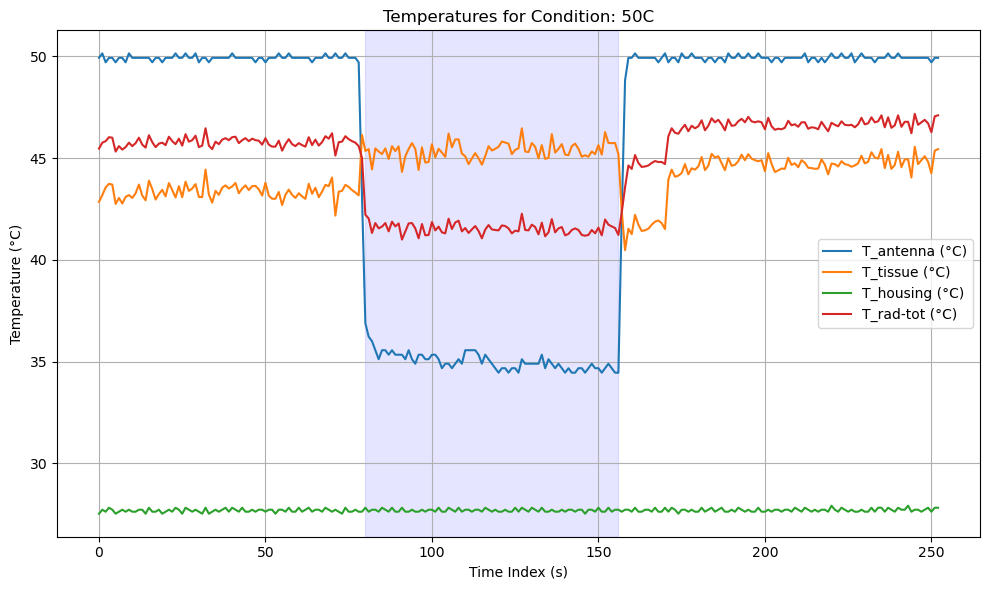

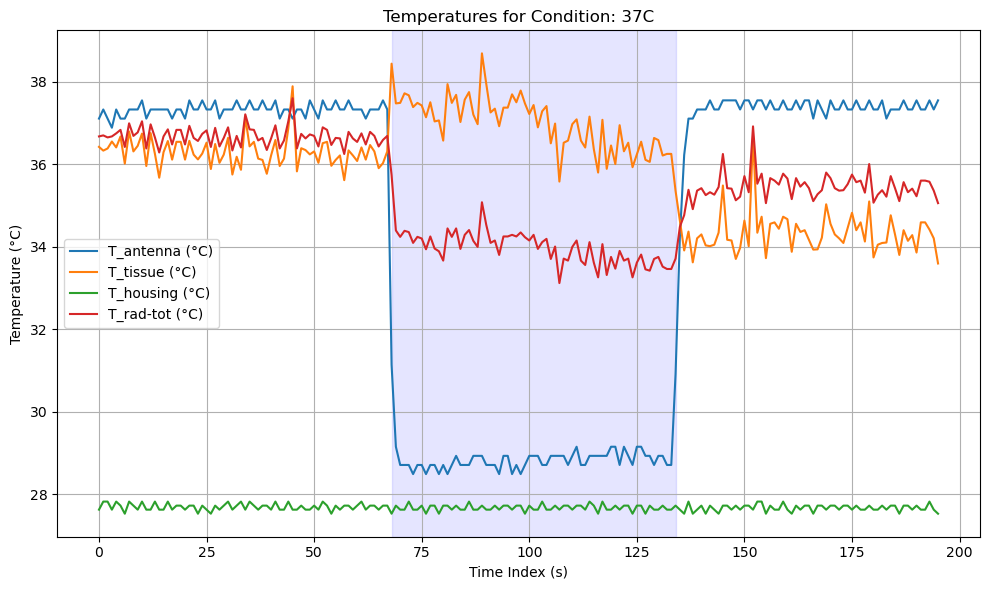

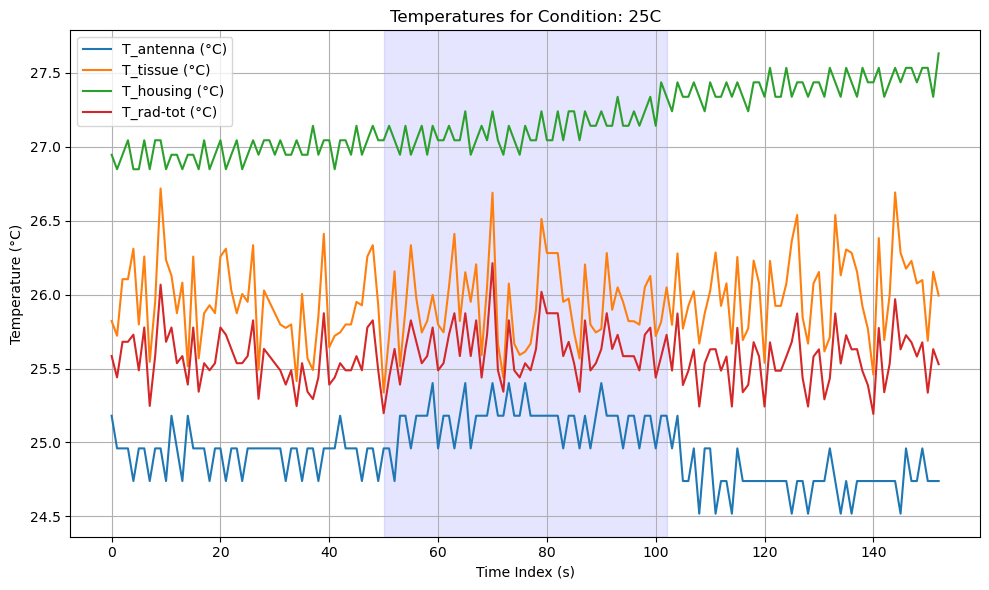

In [21]:
# Plot T_rad-tot, T_antenna, T_tissue vs time_index for each condition, with cooling_flag_1 and cooling_flag_2

temp_vars = [ 'T_antenna', 'T_tissue', 'T_housing', 'T_rad-tot' ]
temp_labels = {
    'T_rad-tot': 'T_rad-tot (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in temp_vars:
        plt.plot(subset['time_index'], subset[var], label=temp_labels[var])
    # Plot cooling_flag_1 and cooling_flag_2 as shaded regions
    for flag_col, color, alpha, label in [
        ('cooling_flag_1', 'blue', 0.1, 'Cooling Flag 1'),
        ('cooling_flag_2', 'green', 0.1, 'Cooling Flag 2')
    ]:
        flag = subset[flag_col].values
        # Find contiguous regions where flag==1
        in_region = False
        start_idx = None
        for i, val in enumerate(flag):
            if val == 1 and not in_region:
                start_idx = i
                in_region = True
            elif val == 0 and in_region:
                plt.axvspan(subset['time_index'].iloc[start_idx], subset['time_index'].iloc[i-1], 
                            color=color, alpha=alpha, label=label if start_idx == i-1 else None)
                in_region = False
        if in_region:
            plt.axvspan(subset['time_index'].iloc[start_idx], subset['time_index'].iloc[-1], 
                        color=color, alpha=alpha, label=label if start_idx == subset['time_index'].iloc[-1] else None)
    # Avoid duplicate legend entries
    handles, plot_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(plot_labels, handles))
    plt.title(f"Temperatures for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Temperature (°C)")
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

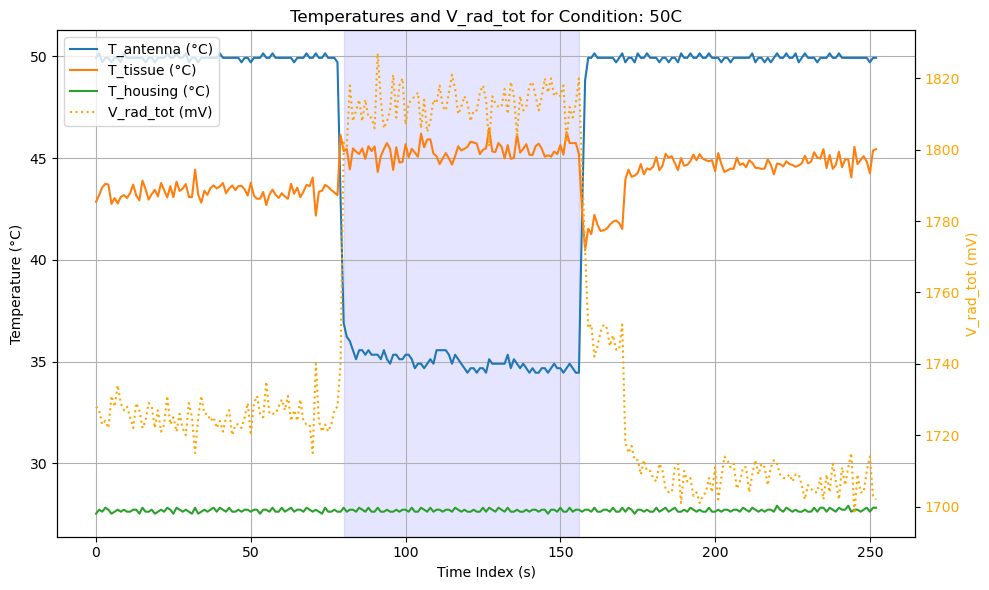

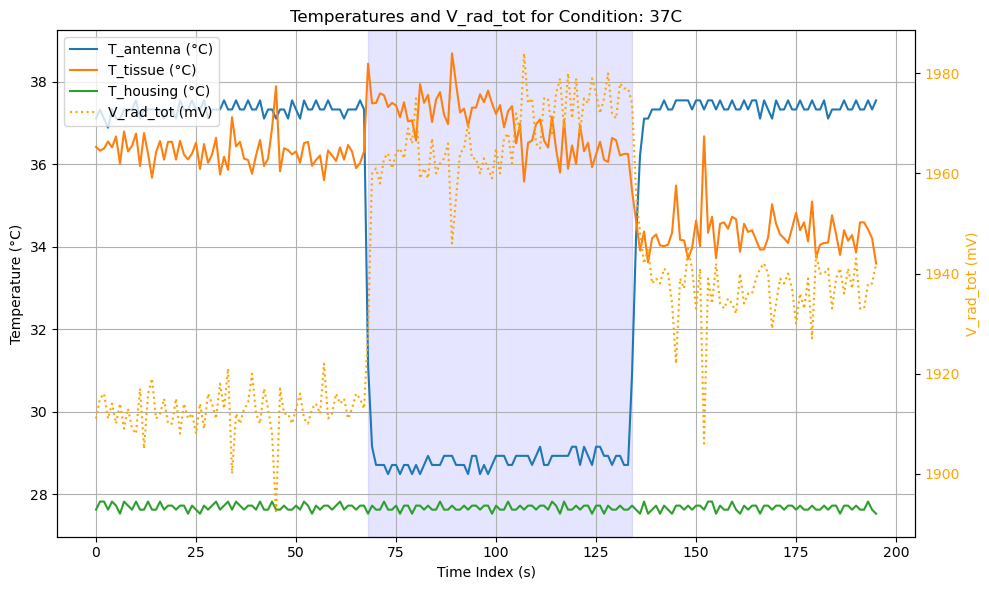

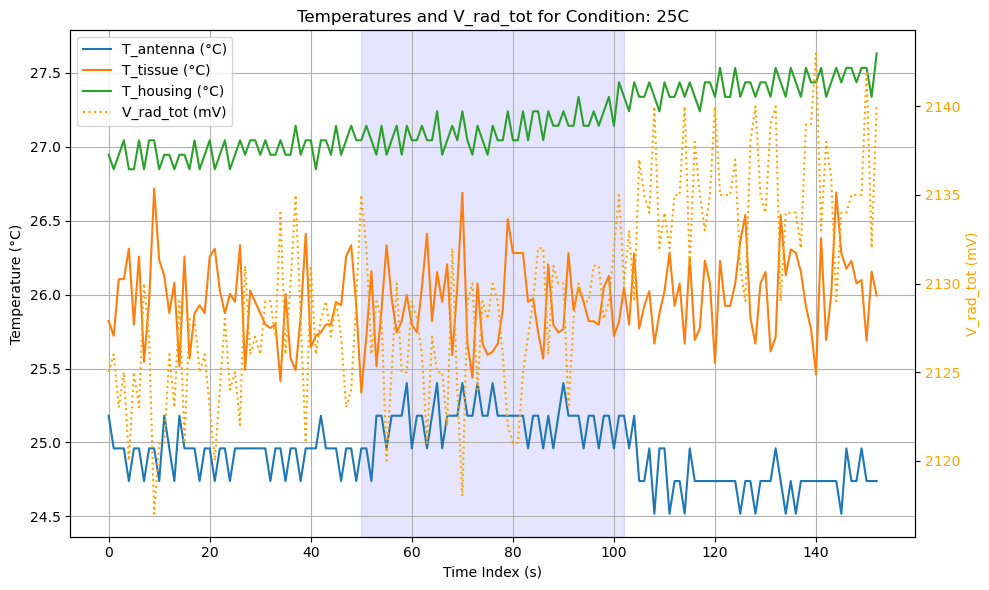

In [22]:
# Plot T_rad-tot, T_antenna, T_tissue vs time_index for each condition, with cooling_flag_1 and cooling_flag_2
# Also plot V_rad_tot (in mV) using the right y-axis

temp_vars = ['T_antenna', 'T_tissue', 'T_housing']
temp_labels = {
    'T_rad-tot': 'T_rad-tot (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Plot temperatures
    for var in temp_vars:
        ax1.plot(subset['time_index'], subset[var], label=temp_labels[var])
    # Plot cooling_flag_1 and cooling_flag_2 as shaded regions
    for flag_col, color, alpha, label in [
        ('cooling_flag_1', 'blue', 0.1, 'Cooling Flag 1'),
        ('cooling_flag_2', 'green', 0.1, 'Cooling Flag 2')
    ]:
        flag = subset[flag_col].values
        in_region = False
        start_idx = None
        for i, val in enumerate(flag):
            if val == 1 and not in_region:
                start_idx = i
                in_region = True
            elif val == 0 and in_region:
                ax1.axvspan(subset['time_index'].iloc[start_idx], subset['time_index'].iloc[i-1],
                            color=color, alpha=alpha, label=label if start_idx == i-1 else None)
                in_region = False
        if in_region:
            ax1.axvspan(subset['time_index'].iloc[start_idx], subset['time_index'].iloc[-1],
                        color=color, alpha=alpha, label=label if start_idx == subset['time_index'].iloc[-1] else None)
    # Right y-axis for V_rad_tot (in mV)
    ax2 = ax1.twinx()
    ax2.plot(subset['time_index'], subset['V_rad_tot'], color='orange', linestyle=':', label='V_rad_tot (mV)')
    ax2.set_ylabel('V_rad_tot (mV)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    # Avoid duplicate legend entries
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels1 + labels2, handles1 + handles2))
    ax1.set_title(f"Temperatures and V_rad_tot for Condition: {cond}")
    ax1.set_xlabel("Time Index (s)")
    ax1.set_ylabel("Temperature (°C)")
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')
    ax1.grid(True)
    fig.tight_layout()
    plt.show()

In [ ]:
30 - 45 (6)